               Timestamp     Price       Diff   StdPrice    StdHigh  \
1790 2023-07-20 19:31:00  29749.08  42.425083  18.462640  23.020781   
1623 2023-07-20 16:44:00  29745.38 -20.945699  14.291886  21.734790   
2780 2023-07-21 12:01:00  29787.12  32.139626   7.792085   9.360759   
776  2023-07-20 02:37:00  30019.00  -0.630683   9.059499  12.837563   
2727 2023-07-21 11:08:00  29786.05 -23.371549   9.564003  14.436759   
...                  ...       ...        ...        ...        ...   
549  2023-07-19 22:50:00  29861.09 -58.195293  19.181314  22.152664   
851  2023-07-20 03:52:00  29937.29  11.417638   4.565098  22.992750   
2918 2023-07-21 14:19:00  29833.37  30.812038  23.902331  44.850022   
2788 2023-07-21 12:09:00  29811.31  43.519655  16.918837  13.555810   
2647 2023-07-21 09:48:00  29799.19 -35.661725  17.273579  29.706745   

         StdLow  Probability_Price_Up  Probability_Price_Down  
1790  21.245908                  1.00                    0.00  
1623  21.276154    

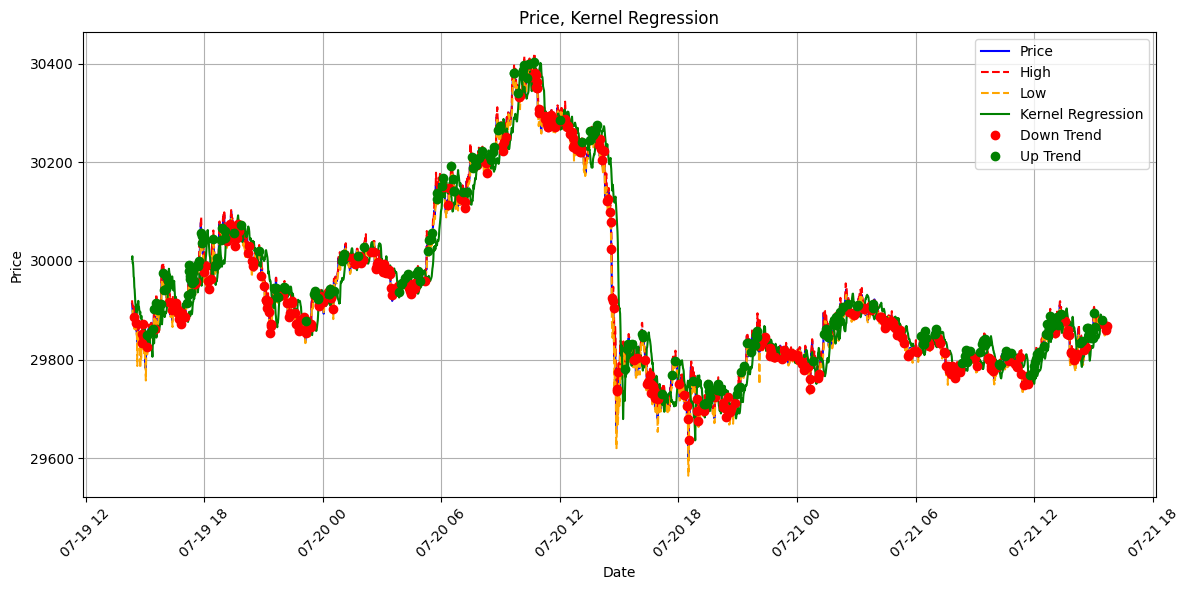

In [1]:
import requests
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time
def get_last_3000_bitcoin_data():
    # Cryptowatch API endpoint for Bitcoin 1-minute data
    base_url = "https://api.cryptowat.ch/markets/coinbase-pro/btcusd/ohlc"
    # Retrieve The Last 3000 data points
    num_data_points = 3000
    # Parameters for the API call in order to retrieve 1 minute data
    params = {
        "periods": 60,  # 1 minute granularity
        "after": int(time.time()) - (60 * num_data_points),  # Timestamp of 3000 minutes ago
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Check for any errors in the API response
        data = response.json()["result"]["60"]
        # Extract the data for Timestamp, Price (closing), High, and Low
        data_points = []
        for point in data:
            timestamp = pd.to_datetime(point[0], unit='s')
            price_usd = point[4]
            high_usd = point[2]
            low_usd = point[3]
            data_points.append([timestamp, price_usd, high_usd, low_usd])
        df = pd.DataFrame(data_points, columns=["Timestamp", "Price", "High", "Low"])
        return df
    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None
if __name__ == "__main__":
    bitcoin_data = get_last_3000_bitcoin_data()
    if not bitcoin_data.empty:  # Check if the DataFrame is not empty
        data_points = []
        for _, row in bitcoin_data.iterrows():  # Iterate over rows of the DataFrame
            timestamp = row["Timestamp"]
            price_usd = row["Price"]
            high_usd = row["High"]  # Add the "High" column
            low_usd = row["Low"]  # Add the "Low" column
            data_points.append([timestamp, price_usd, high_usd, low_usd])
        df = pd.DataFrame(data_points, columns=["Timestamp", "Price", "High", "Low"])
        # Perform Nadaraya-Watson Kernel Regression for each row
        lookback_range = 20
        weighting = 0.70
        regression_level = 1
        lag_factor = 2
        regression_values = []
        for i, row in df.iterrows():
            y = df['Price'].values
            # Calculate kernel weights using KernelDensity
            weights = np.exp(-np.arange(lookback_range) * weighting)
            weights /= np.sum(weights)
            # Apply convolution to calculate predicted values utilizing the look back range
            predicted_values = np.convolve(y, weights[::-1], mode='valid')
            predicted_values = np.pad(predicted_values, (lookback_range - 1, 0), mode='constant', constant_values=np.nan)
            # Apply lag factor
            lag_values = np.concatenate((np.full(int(lag_factor), np.nan), predicted_values[:-int(lag_factor)]))
            #Apply Regression Level
            predicted_values = lag_values * regression_level
            # Get the regression value for the current row
            regression_value = predicted_values[i]
            regression_values.append(regression_value)
        # Add regression values to the dataframe
        df['KernelRegression'] = regression_values
        #Drop na's again
        df = df.dropna(axis=0)
        df['Diff'] = df['Price'] - df['KernelRegression']
        df['HighDiff'] = df['High'] - df['KernelRegression']
        df['LowDiff'] = df['Low'] - df['KernelRegression']
        # Calculate rolling standard deviations for each price column and the Kernel Regression respectively
        df['StdPrice'] = df['Price'].rolling(lookback_range).std()
        df['StdHigh'] = df['HighDiff'].rolling(lookback_range).std()
        df['StdLow'] = df['LowDiff'].rolling(lookback_range).std()
        # Drop Na's again
        df = df.dropna(axis=0)

        # Convert the target variable to binary labels (1 for price going up, 0 for price going down)
        threshold = 10  # Adjust the threshold however required
        df['Target'] = (df['Diff'] > threshold).astype(int)

        # Select features and target variable
        features = df[['Diff', 'StdPrice', 'StdHigh', 'StdLow']]
        target = df['Target']
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
        # Scale that Data!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train an SVM classifier to generate probability estimations based upon the likelihood of movement when the difference between the closing price of bitcoin and the kernel regression equals 20
        svm_classifier = SVC(probability=True)  # Use probability=True to get probability estimates
        svm_classifier.fit(X_train_scaled, y_train)
        # Predict probabilities for the test set
        test_probabilities = svm_classifier.predict_proba(X_test_scaled)
        # Add the probabilities to the DataFrame and scale to the valid range
        df_test = df.loc[X_test.index].copy()
        df_test['Probability_Price_Up'] = test_probabilities[:, 1]  # Probability of price going up
        df_test['Probability_Price_Up'] = np.round(df_test['Probability_Price_Up'], 2)  # Round to 2 decimal places
        df_test['Probability_Price_Down'] = 1 - df_test['Probability_Price_Up']  # Probability of price going down
        df_test['Probability_Price_Down'] = np.clip(df_test['Probability_Price_Down'], 0.0, 0.99)  # Clip to be 0.99 or lower
        print(df_test[['Timestamp', 'Price', 'Diff', 'StdPrice', 'StdHigh', 'StdLow', 'Probability_Price_Up', 'Probability_Price_Down']])
        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(df['Timestamp'], df['Price'], label='Price', color='blue')
        plt.plot(df['Timestamp'], df['High'], label='High', color='red', linestyle='dashed')
        plt.plot(df['Timestamp'], df['Low'], label='Low', color='orange', linestyle='dashed')
        plt.plot(df['Timestamp'], df['KernelRegression'], label='Kernel Regression', color='green')
        # Add red and green dots based on the new probability conditions
        green_dots = df_test[df_test['Probability_Price_Up'] >= 0.90]
        red_dots = df_test[df_test['Probability_Price_Down'] >= 0.90]
        plt.plot(red_dots['Timestamp'], red_dots['Price'], 'ro', label='Down Trend')
        plt.plot(green_dots['Timestamp'], green_dots['Price'], 'go', label='Up Trend')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Price, Kernel Regression')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [2]:
print(df_test['Probability_Price_Down'].unique())
print(df_test['Probability_Price_Up'].unique())

[0.   0.99 0.94 0.59 0.01 0.66 0.04 0.06 0.21 0.24 0.89 0.48 0.07 0.05
 0.91 0.03 0.02 0.75 0.97 0.28 0.62 0.64 0.98 0.93 0.14 0.71 0.84 0.23
 0.37 0.9  0.72 0.76 0.15 0.52 0.1  0.31 0.96 0.29]
[1.   0.   0.06 0.41 0.99 0.34 0.96 0.94 0.79 0.76 0.11 0.52 0.93 0.95
 0.01 0.09 0.97 0.98 0.25 0.03 0.72 0.38 0.36 0.02 0.07 0.86 0.29 0.16
 0.77 0.63 0.1  0.28 0.24 0.85 0.48 0.9  0.69 0.04 0.71]
